# LAB: (quasi-) Newton methods

Author : Alexandre Gramfort

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
and compare your implementation with the BFGS and L-BFGS solvers in scipy

You will need to knowledge on **line search methods** and **conjugate gradient** in particular you should reuse the notebooks presented during the lectures.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 30th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 24 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [91]:
# Change here using YOUR first and last names
fn1 = "leo"
ln1 = "treguer"
fn2 = "mehdi"
ln2 = "miah"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_treguer_leo_and_miah_mehdi.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [92]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print ('%s function took %0.3f ms' % (f.__name__, (time2-time1)*1000.0))
        return ret
    return wrap


%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [93]:
from optim_utils import test_solver

You'll have work only with the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

Let us now make an example with a gradient descent.

In [94]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now I can call the `test_solver` function with this solver:


Running solver on case 1
iter: 1, f: 0.187228, l_inf_norm(grad): 0.35904
iter: 2, f: 0.0522931, l_inf_norm(grad): 0.162853
iter: 3, f: 0.020076, l_inf_norm(grad): 0.110187
iter: 4, f: 0.00874399, l_inf_norm(grad): 0.0745522
iter: 5, f: 0.00395127, l_inf_norm(grad): 0.050442
iter: 6, f: 0.00180287, l_inf_norm(grad): 0.0341291
iter: 7, f: 0.000824643, l_inf_norm(grad): 0.0230917
iter: 8, f: 0.000377432, l_inf_norm(grad): 0.0156239
iter: 9, f: 0.000172774, l_inf_norm(grad): 0.0105711
iter: 10, f: 7.90929e-05, l_inf_norm(grad): 0.00715241
iter: 11, f: 3.62076e-05, l_inf_norm(grad): 0.00483932
iter: 12, f: 1.65754e-05, l_inf_norm(grad): 0.00327429
iter: 13, f: 7.588e-06, l_inf_norm(grad): 0.00221538
iter: 14, f: 3.47369e-06, l_inf_norm(grad): 0.00149893
iter: 15, f: 1.59021e-06, l_inf_norm(grad): 0.00101417
iter: 16, f: 7.2798e-07, l_inf_norm(grad): 0.00068619
iter: 17, f: 3.3326e-07, l_inf_norm(grad): 0.000464276
iter: 18, f: 1.52562e-07, l_inf_norm(grad): 0.000314129
iter: 19, f: 6.98411

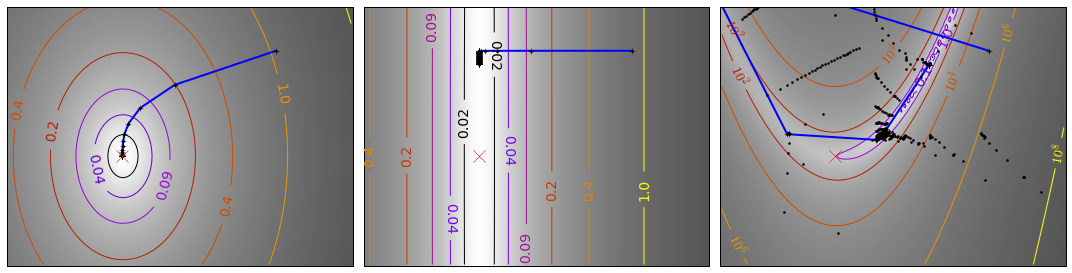

In [95]:
test_solver(gradient_descent)

# Part 2: Implement Newton method

You now need to implement Newton method using either `linalg.solve` or `sparse.linalg.cg` to solve the linear system at each iteration. You need to implement both versions.

You're expected to comment in a few lines what you see.

* First we introduce a timer to time and compare both versions

* Newton method with "linalg.solve"

In [96]:
import scipy.linalg as linalg

In [97]:
@timing
def newton1(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        hessian_x = f_hessian(x)
                        
        ####################################
        # Compute here the search direction
        
        d = - linalg.solve(hessian_x,grad_x)
        
        ####################################

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        ##################################
        # Compute here the new value of x
        x = x+step*d
        ##################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0, l_inf_norm(grad): 0
newton1 function took 0.501 ms

Running solver on case 2
iter: 1, f: 0, l_inf_norm(grad): 0
newton1 function took 0.500 ms

Running solver on case 3
iter: 1, f: 0.357547, l_inf_norm(grad): 1.19858
iter: 2, f: 0.253454, l_inf_norm(grad): 14.6168
iter: 3, f: 0.137976, l_inf_norm(grad): 3.9843
iter: 4, f: 0.088137, l_inf_norm(grad): 6.14586
iter: 5, f: 0.0414804, l_inf_norm(grad): 3.93321
iter: 6, f: 0.0162138, l_inf_norm(grad): 2.7976
iter: 7, f: 0.00446914, l_inf_norm(grad): 1.29953
iter: 8, f: 0.000705202, l_inf_norm(grad): 0.668389
iter: 9, f: 3.34966e-05, l_inf_norm(grad): 0.121298
iter: 10, f: 1.24866e-07, l_inf_norm(grad): 0.00982241
iter: 11, f: 2.01025e-12, l_inf_norm(grad): 3.05844e-05
iter: 12, f: 5.2958e-22, l_inf_norm(grad): 6.41073e-10
newton1 function took 5.003 ms


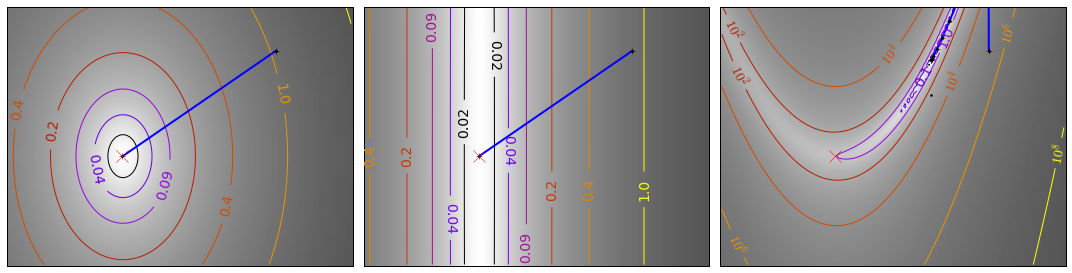

In [98]:
test_solver(newton1)

* Newton Method with "sparse.linalg.cg"

In [99]:
import scipy.sparse.linalg as sparse

In [100]:
@timing
def newton2(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        hessian_x = f_hessian(x)
                        
        ####################################
        # Compute here the search direction
        
        if k == 1:
            d = -sparse.cg(f_hessian(x), grad_x)[0]
        else:
            d = -sparse.cg(f_hessian(x), grad_x, d)[0]
        
        ####################################

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        ##################################
        # Compute here the new value of x
        x = x+step*d
        ##################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0, l_inf_norm(grad): 0
newton2 function took 0.484 ms

Running solver on case 2
iter: 1, f: 3.40668e-26, l_inf_norm(grad): 2.12057e-13
newton2 function took 0.500 ms

Running solver on case 3
iter: 1, f: 0.357547, l_inf_norm(grad): 1.19858
iter: 2, f: 0.253454, l_inf_norm(grad): 14.6168
iter: 3, f: 0.137976, l_inf_norm(grad): 3.9843
iter: 4, f: 0.088137, l_inf_norm(grad): 6.14586
iter: 5, f: 0.0414804, l_inf_norm(grad): 3.93321
iter: 6, f: 0.0162138, l_inf_norm(grad): 2.7976
iter: 7, f: 0.00446914, l_inf_norm(grad): 1.29953
iter: 8, f: 0.000705202, l_inf_norm(grad): 0.668389
iter: 9, f: 3.34966e-05, l_inf_norm(grad): 0.121298
iter: 10, f: 1.24866e-07, l_inf_norm(grad): 0.00982241
iter: 11, f: 2.01025e-12, l_inf_norm(grad): 3.05844e-05
iter: 12, f: 5.2958e-22, l_inf_norm(grad): 6.41073e-10
newton2 function took 7.488 ms


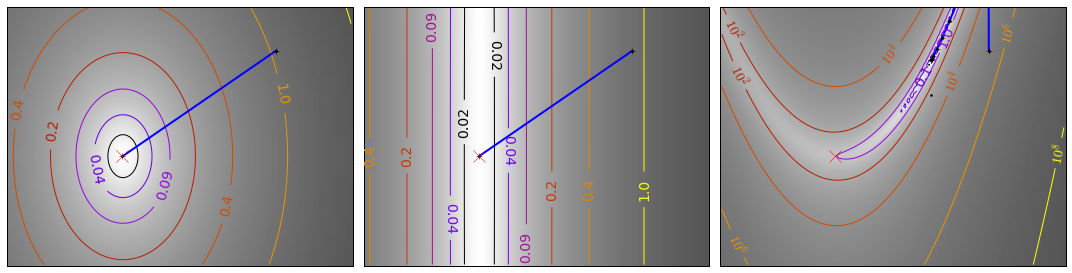

In [101]:
test_solver(newton2)

We notice that for the two first functions, which are quadratic, the Newton algorithm converges in one iteration, for both the "linalg.solve" solver and the "sparse.linalg.cg" solver. Indeed, as seen in the course, these two functions have the form $f(x)=\frac{1}{2}x^TAx-bx-c$ with A symmetric positive definite. The Newton method converges in one iteration independently of the choice of $x_0$. This is why it converges faster than the Gradient Descent algorithm.

For the third function, which is not quadratic, we notice that the Newton method converges in 12 iterations.

We also notice that the "sparse.linalg.cg" solver takes approximately twice as long as for the "linalg.solve" solver, for the three functions. 



# Part 2: Implement DFP algorithm

You now need to implement the DFP algorithm.

In [102]:
@timing
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        ####################################
        # Compute here the search direction
            
        d=-np.dot(B,grad_x)
        ####################################

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        ##################################
        # Compute here the new value of x
        s=step*d
        x=x+s
            
        ##################################
        
        #########################################################
        # Update the inverse Hessian approximation
        # We use the formula at the slide 17th of the lesson
        
        y= new_grad - grad_x
            
        term1 = np.dot(s.reshape(len(s),1),s.reshape(1,len(s)))/np.dot(s,y)
        term2 = np.dot(B,np.dot(y.reshape(len(y),1),np.dot(y.reshape(1,len(y)),B)))/np.dot(y,np.dot(B,y))
        B = B + term1 - term2
        #aux1 = (np.dot(s.reshape(len(s), 1), s.reshape(1, len(s))))/(np.dot(s, y))
        #aux2 = (np.dot(B, np.dot(y.reshape(len(y), 1), np.dot(y.reshape(1, len(y)), B)))) / (np.dot(y, np.dot(B, y)))
        #B += aux1 - aux2
        #########################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0.187228, l_inf_norm(grad): 0.35904
iter: 2, f: 0.0214911, l_inf_norm(grad): 0.114753
iter: 3, f: 0.00899657, l_inf_norm(grad): 0.069501
iter: 4, f: 0.00023476, l_inf_norm(grad): 0.0175216
iter: 5, f: 1.76801e-05, l_inf_norm(grad): 0.00465113
iter: 6, f: 3.20353e-08, l_inf_norm(grad): 0.000140183
iter: 7, f: 1.32183e-10, l_inf_norm(grad): 8.99094e-06
iter: 8, f: 8.82459e-15, l_inf_norm(grad): 1.04309e-07
dfp function took 1.501 ms

Running solver on case 2
iter: 1, f: 0.0978185, l_inf_norm(grad): 0.35904
iter: 2, f: 0.000159508, l_inf_norm(grad): 0.000290207
iter: 3, f: 0.000138677, l_inf_norm(grad): 0.000270594
iter: 4, f: 1.92681e-07, l_inf_norm(grad): 0.000503909
iter: 5, f: 1.4273e-07, l_inf_norm(grad): 0.000433799
iter: 6, f: 3.512e-14, l_inf_norm(grad): 1.6706e-08
dfp function took 1.499 ms

Running solver on case 3
iter: 1, f: 104.123, l_inf_norm(grad): 700.972
iter: 2, f: 7.56575, l_inf_norm(grad): 24.138
iter: 3, f: 7.34339, l_inf_norm(gra

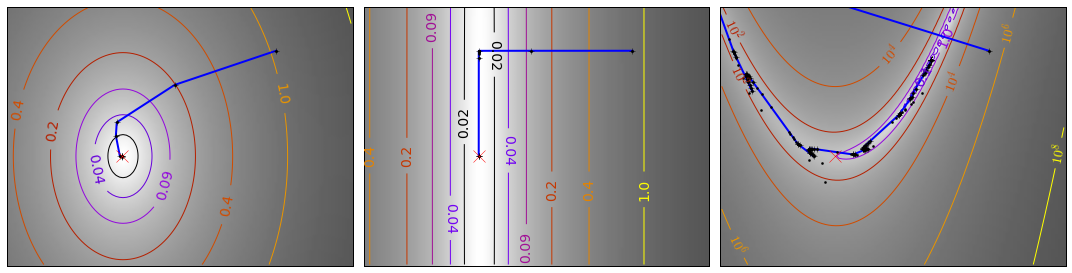

In [103]:
test_solver(dfp)

We notice that the DFP algorithm converges in 8 iterations for the first function, and in 6 iterations for the second function. 
For the third function, which is not quadratic, we notice that the convergence takes much more time as it takes 95 iterations. 

In the course, we learnt that the convergence speed for the DFP algorithm is n iterations, where n is the dimension of x. For the two first functions, the dimension of x is 2 but the convergence speed is not 2. This is linked to the fact that we use a line search function to update the step size $\rho_k$, which is an estimation of the optimal step size seen in the DFP algorithm theorem.

# Part 3: Implement BFGS algorithm

You now need to implement the BFGS algorithm.

In [104]:
@timing
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    H = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        ####################################
        # Compute here the search direction
        d = -linalg.solve(H, grad_x)
        ####################################

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        ##################################    
        # Compute here the new value of x
        s = step * d
        x = x + s
        ##################################
        
        #####################################################
        # Update the Hessian approximation   
        y = new_grad - grad_x
        term1=np.dot(y.reshape(len(y),1),y.reshape(1,len(y)))/np.dot(y,s)
        term2=np.dot(H,np.dot(np.dot(s.reshape(len(s),1),s.reshape(1,len(s))),H))/np.dot(s,np.dot(H,s))
        H = H + term1 - term2
        #####################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0.187228, l_inf_norm(grad): 0.35904
iter: 2, f: 0.0209281, l_inf_norm(grad): 0.11324
iter: 3, f: 0.00806831, l_inf_norm(grad): 0.0656686
iter: 4, f: 3.9809e-05, l_inf_norm(grad): 0.00723054
iter: 5, f: 4.69973e-07, l_inf_norm(grad): 0.000735419
iter: 6, f: 7.22702e-11, l_inf_norm(grad): 6.78586e-06
iter: 7, f: 2.47614e-14, l_inf_norm(grad): 1.18656e-07
bfgs function took 2.504 ms

Running solver on case 2
iter: 1, f: 0.0978185, l_inf_norm(grad): 0.35904
iter: 2, f: 0.000159508, l_inf_norm(grad): 0.000290207
iter: 3, f: 0.000119306, l_inf_norm(grad): 0.00025098
iter: 4, f: 6.91982e-13, l_inf_norm(grad): 9.54949e-07
bfgs function took 3.015 ms

Running solver on case 3
iter: 1, f: 104.123, l_inf_norm(grad): 700.972
iter: 2, f: 7.59071, l_inf_norm(grad): 26.034
iter: 3, f: 7.34411, l_inf_norm(grad): 4.87129
iter: 4, f: 7.29555, l_inf_norm(grad): 8.30631
iter: 5, f: 6.98403, l_inf_norm(grad): 49.3631
iter: 6, f: 6.72314, l_inf_norm(grad): 26.9831
iter:

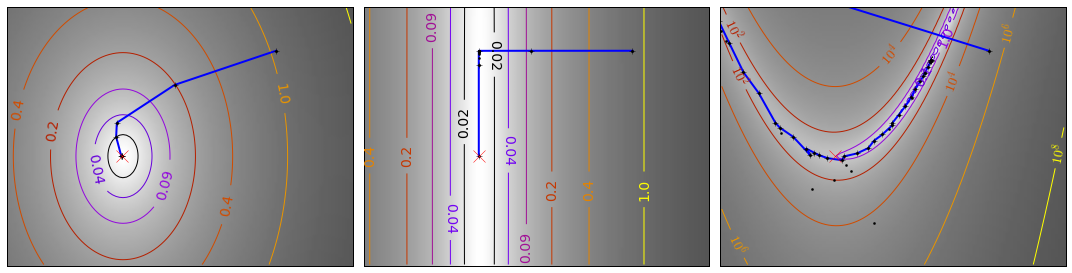

In [105]:
test_solver(bfgs)

For the first and second function, which are quadratic, the convergence takes 7 and 4 iterations. But as for the DFP algorithm, the BFGS algorithm does not take 2 iterations as it is supposed to for quadratic functions.
For the third function, the convergence takes 42 iterations. 

We notice that the convergence is faster with the BFGS algorithm, as it is less sensitive than DFP to the use of the line search function to compute the approximate step size. 


# Part 4: Do the same now with scipy implementation of BFGS and L-BFGS

In [110]:
from scipy.optimize import fmin_bfgs, fmin_l_bfgs_b
from scipy.optimize import rosen as rosenbrock
from optim_utils import mk_quad

For this part, we cannot use the function `test_solver` since the arguments of `fmin_bfgs` and `fmin_l_bfgs_b` do not follow the same pattern.

### Implementation of BFGS under scipy

In [112]:
x0 = np.array([1.6, 1.1])

print('BFGS for quadratic 0.7')
fmin_bfgs(mk_quad(0.7)[0], x0, retall = False)

print('\nBFGS for quadratic 0.02')
fmin_bfgs(mk_quad(0.02)[0], x0, retall = False)

print('\n BFGS for Rosenbrock')
fmin_bfgs(rosenbrock, x0, retall = False)

BFGS for quadratic 0.7
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 28
         Gradient evaluations: 7

BFGS for quadratic 0.02
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 76
         Gradient evaluations: 19

 BFGS for Rosenbrock
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 164
         Gradient evaluations: 38


array([ 0.99999724,  0.99999454])

Here, with the function BFGS of scipy, one can get the following results : 
* for a quadratic function, the algorithm converges in much or less 5 iterations ; 
* for the Rosenbrock function, it takes 17 iterations to converge.

It seems that this function works faster than the one we implemented ; the difference of results is more important for the non quadratic function.

### Implementation of L-BFGS under scipy

In [115]:
x0 = np.array([1.6, 1.1])

print('BFGS for quadratic 0.7')
x,f,d = fmin_l_bfgs_b(mk_quad(0.7)[0], x0, approx_grad= 1)
print(d)

print('\nBFGS for quadratic 0.02')
x,f,d = fmin_l_bfgs_b(mk_quad(0.02)[0], x0, approx_grad= 1)
print(d)

print('\n BFGS for Rosenbrock')
x,f,d = fmin_l_bfgs_b(rosenbrock, x0, approx_grad= 1)
print(d)

BFGS for quadratic 0.7
{'funcalls': 18, 'warnflag': 0, 'grad': array([  1.87237906e-06,   7.07716289e-07]), 'nit': 5, 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'}

BFGS for quadratic 0.02
{'funcalls': 27, 'warnflag': 0, 'grad': array([ -4.12210175e-07,   2.70761823e-10]), 'nit': 4, 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'}

 BFGS for Rosenbrock
{'funcalls': 66, 'warnflag': 0, 'grad': array([  1.47249105e-08,   5.59104987e-09]), 'nit': 19, 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'}


Here, with the function L-BFGS of scipy, one can get the following results : 
* the convergence is reached for the quadratic problems in less than 5 iterations ;
* for the Rosenbrock function, the algorithm converges in 19 iterations.

L-BFGS is better when the memory is limited. Here, with only 2 dimensions, L-BFGS is not a breakthrough.

To sum up, we have the following results for the number of iterations : 

Algorithm | Quadratic function with good condition | Quadratic function with bad conditioning | Rosenbrock function
- |:-: | :-: | :-:
**Gradient descent** | 33 | > 100 | > 100
**Newton with solve** | 1 | 1 | 12
**Newton with conjugate gradient** | 1 | 1 | 12
**DFP** | 8 | 6 | 95
**Own BFGS** | 7 | 4 | 42
**scipy BFGS** | 6 | 5 | 17
**scipy L-BFGS** | 5 | 4 | 19